In [2]:
import os

In [3]:
os.chdir('../')

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 1 2 1 0 1 1 0 1 0 0 1 1 0 2 0 0 0 0 1 0 1 2 0 0 1 1 1 0 0 1]


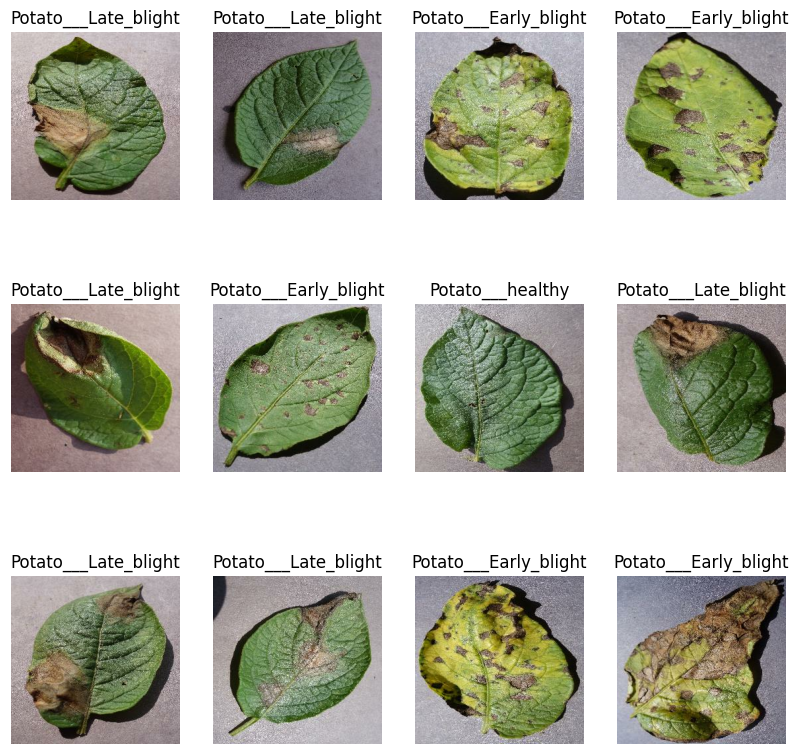

In [9]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

In [10]:
len(dataset)

68

In [11]:
EPOCHS = 50

In [12]:
train_size = 0.8
round(len(dataset)*train_size)

54

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
type(test_ds.take(1))

tensorflow.python.data.ops.take_op._TakeDataset

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [32]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [33]:
CHANNELS =3

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 230s 3s/step - loss: 0.9399 - accuracy: 0.4873 - val_loss: 0.8810 - val_accuracy: 0.6146
Epoch 2/50
54/54 [==============================] - 134s 2s/step - loss: 0.7381 - accuracy: 0.6424 - val_loss: 0.5257 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 126s 2s/step - loss: 0.4700 - accuracy: 0.7975 - val_loss: 0.3109 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 127s 2s/step - loss: 0.3268 - accuracy: 0.8715 - val_loss: 0.2109 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 118s 2s/step - loss: 0.2356 - accuracy: 0.9109 - val_loss: 0.1312 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 117s 2s/step - loss: 0.1902 - accuracy: 0.9294 - val_loss: 0.1836 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 117s 2s/step - loss: 0.1303 - accuracy: 0.9531 - val_loss: 0.1010 - val_accuracy: 0.9740
Epoch 8/50
54

In [38]:
import pickle

In [39]:
with open('./artifacts/trained_model.pkl',"wb") as model_obj:
    pickle.dump(model,model_obj)

In [29]:
with open('./artifacts/trained_model.pkl','rb') as model_read_obj:
    model = pickle.load(model_read_obj)

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 575ms/step
predicted label: Potato___Early_blight


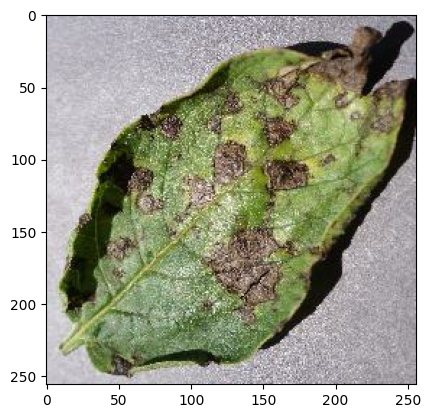

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


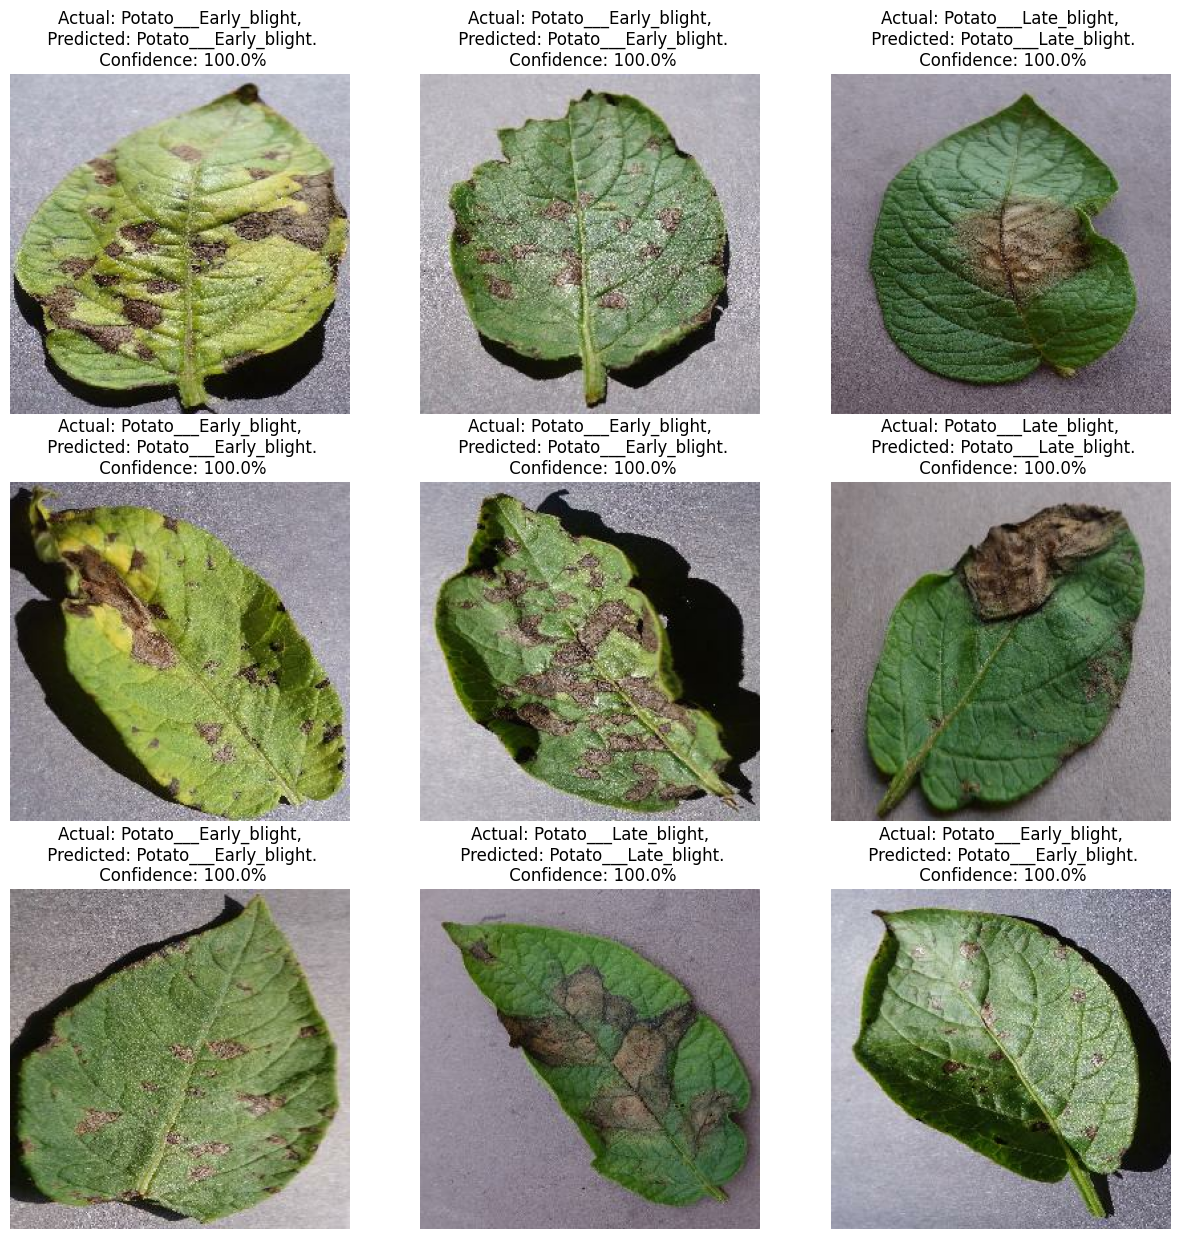

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
for im,lab in test_ds.take(1):
    for i in range(5):
        #print(im[i].numpy())
        img_array = tf.keras.preprocessing.image.img_to_array(im[i].numpy())
        print(img_array)
        print('++++++++++++++++++++++++++++++')
        img_array = tf.expand_dims(img_array, 0)
        print(img_array)
        print()
        print('*****************************')

[[[179. 177. 188.]
  [182. 180. 191.]
  [185. 183. 194.]
  ...
  [143. 140. 149.]
  [147. 144. 153.]
  [147. 144. 153.]]

 [[186. 184. 195.]
  [188. 186. 197.]
  [187. 185. 196.]
  ...
  [142. 139. 148.]
  [140. 137. 146.]
  [137. 134. 143.]]

 [[179. 177. 188.]
  [182. 180. 191.]
  [182. 180. 191.]
  ...
  [160. 157. 166.]
  [162. 159. 168.]
  [155. 152. 161.]]

 ...

 [[197. 194. 201.]
  [198. 195. 202.]
  [199. 196. 203.]
  ...
  [167. 162. 168.]
  [153. 148. 154.]
  [148. 143. 149.]]

 [[201. 198. 205.]
  [201. 198. 205.]
  [202. 199. 206.]
  ...
  [161. 156. 162.]
  [158. 153. 159.]
  [173. 168. 174.]]

 [[204. 201. 208.]
  [205. 202. 209.]
  [205. 202. 209.]
  ...
  [170. 165. 171.]
  [155. 150. 156.]
  [160. 155. 161.]]]
++++++++++++++++++++++++++++++
tf.Tensor(
[[[[179. 177. 188.]
   [182. 180. 191.]
   [185. 183. 194.]
   ...
   [143. 140. 149.]
   [147. 144. 153.]
   [147. 144. 153.]]

  [[186. 184. 195.]
   [188. 186. 197.]
   [187. 185. 196.]
   ...
   [142. 139. 148.]
   [